# Example: 1D Gaussian KAN

Setup: Our goal is to learn a 1D function from samples. The 1D function has 5 Gaussian peaks. Instead of presenting all samples to NN all at once, we have five phases of learning. In each phase only samples around one peak is presented to KAN. We find that KANs can do continual learning thanks to locality of splines.

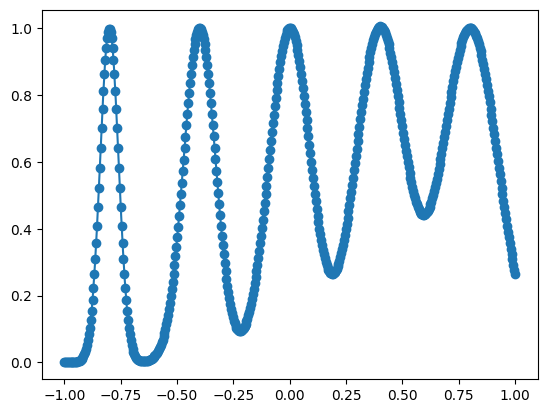

In [15]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt


datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)
x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)

y = 0.
i=1
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*(300/i))
    i += 2
    
y_sample = 0.
i=1
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*(300/i))
    i += 2
    
plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

Sequentially prensenting different peaks to KAN

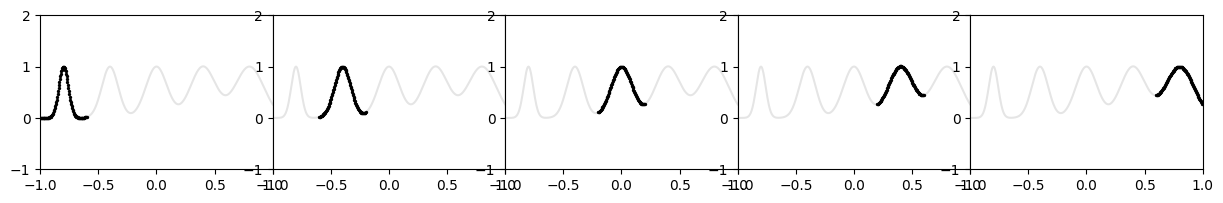

In [16]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)
plt.savefig("/home/thealch3mist/University/Thesis/KANT_Forget/Figures/toy_data_input.png")

Training KAN

checkpoint directory created: ./model
saving model version 0.0
cuda


| train_loss: 3.09e-03 | test_loss: 3.09e-03 | reg: 3.30e+00 | : 100%|█| 50/50 [00:02<00:00, 20.37it


saving model version 0.1


| train_loss: 2.29e-04 | test_loss: 2.29e-04 | reg: 3.30e+00 | : 100%|█| 50/50 [00:02<00:00, 22.98it


saving model version 0.2


| train_loss: 7.49e-05 | test_loss: 7.49e-05 | reg: 3.18e+00 | : 100%|█| 50/50 [00:01<00:00, 27.64it


saving model version 0.3


| train_loss: 3.75e-05 | test_loss: 3.75e-05 | reg: 3.04e+00 | : 100%|█| 50/50 [00:02<00:00, 20.69it


saving model version 0.4


| train_loss: 2.29e-05 | test_loss: 2.29e-05 | reg: 3.01e+00 | : 100%|█| 50/50 [00:02<00:00, 23.80it


saving model version 0.5


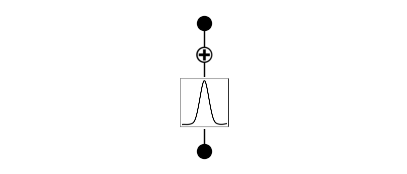

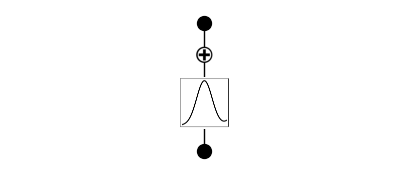

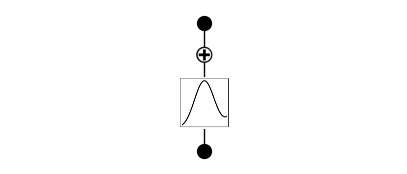

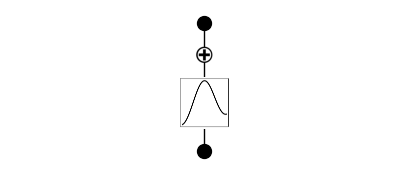

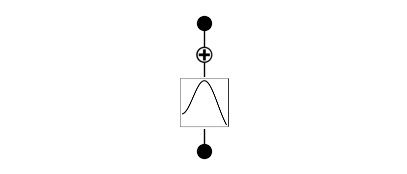

In [17]:
import sys
from avalanche.models import SimpleMLP
from kan import KAN

ys = []

model = KAN(width=[1,1], grid=50, k=3, noise_scale=0.1, sp_trainable=False, sb_trainable=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
for group_id in range(n_peak):
    dataset = {}

    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    model.fit(dataset, opt='LBFGS', steps=50, update_grid=False)
    model.plot(beta=100)
    # plt.show()
    y_pred = model(x_grid[:,None].to(device))
    ys.append(y_pred.cpu().detach().numpy()[:,0])

    

Prediction of KAN after each stage

(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)


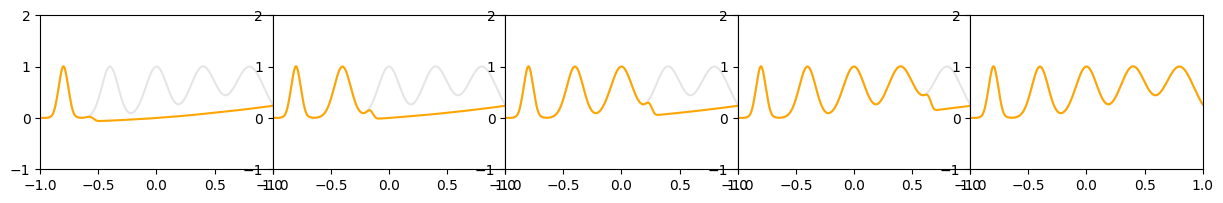

In [18]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    # ys[i-1] = ys[i-1].cpu()
    print(x_grid.detach().numpy().shape,ys[i-1].shape)
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='orange')
    plt.xlim(-1,1)
    plt.ylim(-1,2)

plt.savefig('/home/thealch3mist/University/Thesis/KANT_Forget/Figures/test.png')

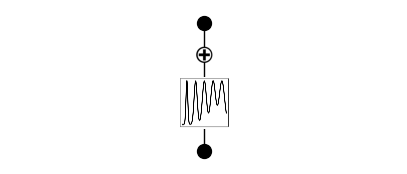

In [19]:
# import ipywidgets as widgets 
# from ipywidgets import interact, interactive, fixed 
# # model.plot(beta=100)
# layers = []
# for layer in model.modules():
#     layers.append(layer)

# layer = layers[0]
# print(layers)

# def plot_curve_with_slider(j):
#     x_conv, y_conv = layer[1].plot_curve(0, j, num_pts=100, num_extrapolate_bins=3)
#     x_conv, y_conv = x_conv.cpu().numpy(), y_conv.cpu().numpy()
#     plt.plot(x_conv, y_conv, label='Conv')
#     plt.legend()
#     plt.show()
# # Create an interactive slider
# interactive_plot = interactive(plot_curve_with_slider, j=widgets.SelectionSlider(options=[i for i in range(1)]))
# output = interactive_plot.children[-1]
# output.layout.height = '500px'
# interactive_plot
model.plot(beta=100)